# Анализ A/B/n тестов для приложения доставки готовых продуктов

## Контекст бизнес-задачи

Работаю аналитиком в приложении по доставке готовых продуктов. Ко мне обратился коллега с результатами двух проведенных A/B тестов, требующих статистической проверки:

### Тест 1: Оптимизация формата фотографий блюд
**Гипотеза:** Изменение формата изображений блюд повлияет на количество заказов
- **Группа A**: прямоугольные фотографии 16:9
- **Группа B**: квадратные фотографии  
- **Группа C**: прямоугольные фотографии 12:4

### Тест 2: Обновление дизайна кнопки заказа
**Гипотеза:** Новый дизайн кнопки увеличит конверсию
- **Control группа**: старая версия кнопки
- **Test группа**: новая версия кнопки

## Цели анализа

1. **Для теста с фотографиями:**
   - Выбрать подходящий статистический метод
   - Проверить гомогенность дисперсий
   - Оценить нормальность распределений
   - Сравнить средние значения между группами
   - Использовать критерий Тьюки для post-hoc анализа
   - Принять решение о выборе оптимального формата

2. **Для теста с кнопкой:**
   - Выбрать метод анализа с учетом сегментов пользователей
   - Визуализировать распределения событий
   - Проанализировать описательные статистики
   - Построить и проверить статистическую модель

## Данные для анализа

### Тест 1 (форматы фотографий)
- `id` - идентификатор клиента
- `group` - экспериментальная группа (A/B/C)
- `events` - количество заказанных блюд

### Тест 2 (дизайн кнопки)  
- `id` - идентификатор клиента
- `segment` - сегмент пользователя (high/low)
- `group` - экспериментальная группа (control/test)
- `events` - количество заказанных блюд

Приступаю к поэтапному анализу обоих экспериментов.

### Шаг 1: Выбор статистического метода для сравнения форматов фотографий

Перед началом анализа необходимо выбрать корректный статистический метод для сравнения средних значений между тремя экспериментальными группами.

**Особенности эксперимента:**
- Имеем три независимые группы (A, B, C)
- Необходимо сравнить среднее количество заказов между группами
- Метод должен учитывать множественные сравнения

**Выбранный метод:**
**Однофакторный дисперсионный анализ (ANOVA)**

**Обоснование выбора:**
1. **ANOVA** предназначен для сравнения средних значений в трех и более группах
2. Позволяет определить, существуют ли статистически значимые различия между любыми из групп
3. Избегает проблемы множественных сравнений, которая возникает при попарных t-тестах
4. Эффективно работает с количественной переменной `events` (количество заказов)

**Гипотезы для ANOVA:**
- **H₀**: Средние количества заказов во всех группах равны
- **H₁**: Хотя бы в одной группе среднее количество заказов отличается от других

После проведения ANOVA, в случае значимых различий, будет применен post-hoc анализ для определения конкретных пар групп с различиями.

In [ ]:
import pandas as pd
import scipy.stats as st
import pingouin as pg
from matplotlib import pyplot as plt 
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.stats.api import anova_lm

In [ ]:
photo_df = pd.read_csv('photo_test.csv')
button_df = pd.read_csv('button_test.csv')

In [10]:
photo_a = photo_df.query('group == "A"')
photo_b = photo_df.query('group == "B"')
photo_c = photo_df.query('group == "C"')
photo_df


,id,group,events
0,16046,A,14
1,18712,A,41
2,3268,A,30
3,22633,A,37
4,28071,A,38
...,...,...,...
29995,22932,C,38
29996,21787,C,25
29997,5054,C,34
29998,10254,C,27


In [5]:
button_df

,id,group,segment,events
0,83440,test,high,78.0
1,96723,test,high,71.0
2,68719,test,high,80.0
3,50399,test,high,80.0
4,95613,test,high,78.0
...,...,...,...,...
99995,60695,control,low,15.0
99996,5934,control,low,16.0
99997,30046,control,low,22.0
99998,26474,control,low,21.0


### Шаг 2: Проверка гомогенности дисперсий

Перед проведением ANOVA необходимо проверить одно из ключевых предположений метода - гомогенность дисперсий между группами. Для этого использую тест Левена.

In [14]:
st.levene(photo_a.events,photo_c.events,photo_b.events)

LeveneResult(statistic=2.262259633931803, pvalue=0.1041327199523974)

**Результаты теста Левена:**
- **Статистика**: 2.26
- **p-value**: 0.104

**Интерпретация результатов:**
- p-value = 0.104 > 0.05
- **Не отклоняем нулевую гипотезу** о равенстве дисперсий

**Вывод:**
Дисперсии количества заказов в группах A, B и C являются статистически однородными. Это означает, что:
- Разброс данных вокруг среднего значения примерно одинаков во всех группах
- Условие гомогенности дисперсий для ANOVA выполнено
- Можно корректно применять дисперсионный анализ

### Шаг 3: Проверка нормальности распределений

Для проверки второго ключевого предположения ANOVA - нормальности распределений - использовал два взаимодополняющих метода: статистический тест нормальности и визуальный анализ QQ-графиков.

In [23]:
pg.normality(data=photo_df, dv="events", group="group", method="normaltest")

,W,pval,normal
group,,,
A,2.103460,0.349333,True
B,0.841072,0.656695,True
C,3.243726,0.197530,True


Text(0.5, 1.0, 'C')

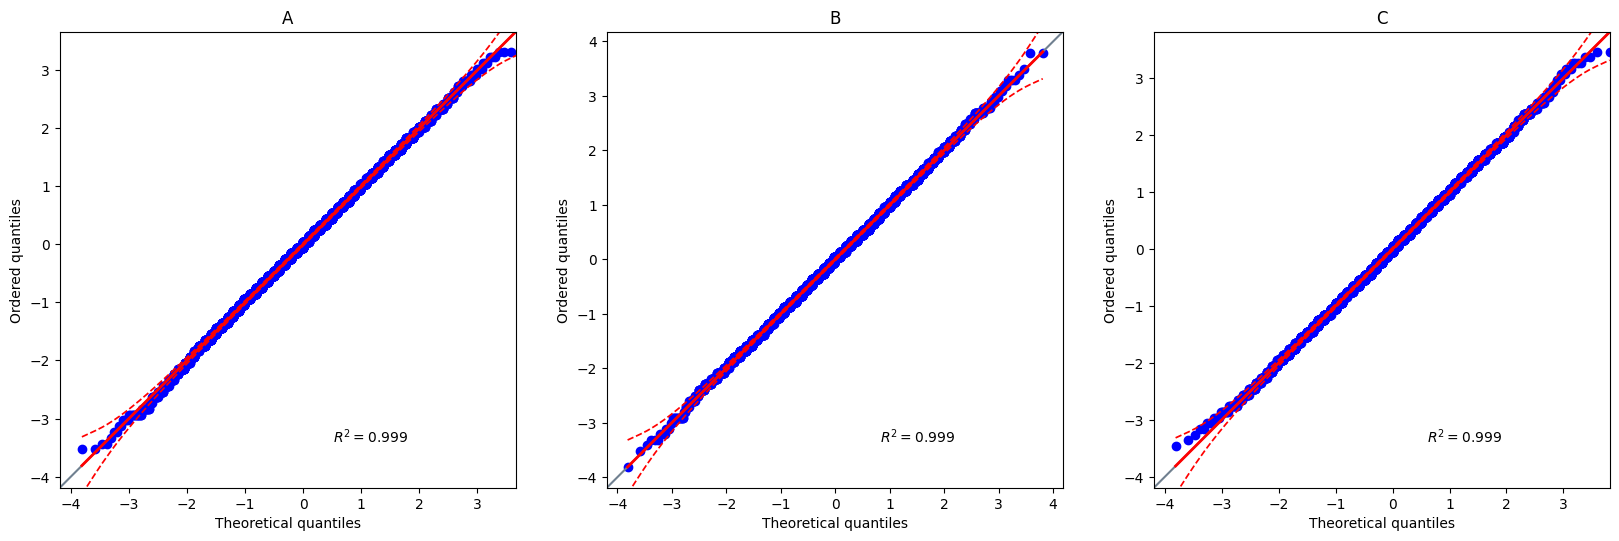

In [30]:
plt.figure(figsize=(20,7))
plt.subplot(1,3,1)
pg.qqplot(photo_a.events)
plt.title('A')
plt.subplot(1,3,2)
pg.qqplot(photo_b.events)
plt.title('B')
plt.subplot(1,3,3)
pg.qqplot(photo_c.events)
plt.title('C')

**Результаты теста нормальности (Агостино-Пирсон):**

| Группа | Статистика | p-value | Нормальное |
|--------|------------|---------|------------|
| A      | 2.10       | 0.349   | True       |
| B      | 0.84       | 0.657   | True       |
| C      | 3.24       | 0.198   | True       |

**Анализ QQ-графиков:**
- Все три графика демонстрируют точки, близко расположенные к диагональной линии
- Отсутствуют существенные отклонения в "хвостах" распределений
- Распределения в группах визуально соответствуют нормальному

**Совокупный вывод:**
Оба метода - статистический тест и визуальный анализ QQ-графиков - согласованно подтверждают, что распределения количества заказов во всех трех группах являются нормальными.

**Итог проверки предположений ANOVA:**

✅ **Гомогенность дисперсий** - выполнено (тест Левена, p = 0.104)  
✅ **Нормальность распределений** - выполнено во всех группах

Все условия для применения дисперсионного анализа соблюдены, можно переходить к сравнению средних между группами.

### Шаг 4: Проверка различий между группами с помощью ANOVA

Проведу однофакторный дисперсионный анализ для сравнения среднего количества заказов между тремя группами с разными форматами фотографий.


In [36]:
formula = "events ~ C(group)"
model = smf.ols(formula = formula, data= photo_df).fit()
anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
C(group),2.0,5.729361e+05,286468.062300,2886.166657,0.0
Residual,29997.0,2.977369e+06,99.255551,NaN,NaN


**Результаты ANOVA:**
- **F-статистика**: 2886 (округлено до целого)
- **p-value**: 0.0

**Статистические гипотезы:**
- **H₀**: μ_A = μ_B = μ_C (средние количества заказов равны во всех группах)
- **H₁**: ∃ i,j: μ_i ≠ μ_j (хотя бы одна группа отличается от других)

**Интерпретация результатов:**
- p-value ≈ 0.0 < 0.05 → **отвергаем нулевую гипотезу**
- F-статистика чрезвычайно высока (2886), что указывает на очень сильные различия между группами
- Статистически значимые различия в среднем количестве заказов существуют

### Шаг 5: Post-hoc анализ с критерием Тьюки

После обнаружения значимых различий в ANOVA провел попарное сравнение групп с помощью критерия Тьюки для определения конкретных пар с статистически значимыми различиями.

In [ ]:
pg.pairwise_tukey(data = photo_df, dv = 'events', between = 'group')

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,A,B,29.5796,37.6136,-8.0340,0.140894,-57.021604,0.0,-0.806229
1,A,C,29.5796,27.4703,2.1093,0.140894,14.970833,0.0,0.210514
2,B,C,37.6136,27.4703,10.1433,0.140894,71.992436,0.0,1.024138


**Результаты попарного сравнения:**

| Сравнение | Mean(A) | Mean(B) | Разница | p-value | Значимость |
|-----------|---------|---------|---------|---------|------------|
| A vs B    | 29.58   | 37.61   | -8.03   | 0.0     | ✅ **Да**   |
| A vs C    | 29.58   | 27.47   | 2.11    | 0.0     | ✅ **Да**   |
| B vs C    | 37.61   | 27.47   | 10.14   | 0.0     | ✅ **Да**   |

**Анализ результатов:**
- **Все попарные сравнения статистически значимы** (p-value = 0.0 для всех пар)
- **Группа B** (квадратные фото) показывает наивысшее среднее количество заказов (37.61)
- **Группа A** (прямоугольные 16:9) занимает промежуточное положение (29.58)
- **Группа C** (прямоугольные 12:4) имеет наименьшее количество заказов (27.47)

**Размер эффекта (Hedges):**
- Наибольший эффект наблюдается между группами B и C (1.02 - очень сильный эффект)
- Эффект между A и B составляет -0.81 (сильный отрицательный)
- Эффект между A и C - 0.21 (слабый положительный)

**Вывод:** Все три формата фотографий статистически значимо отличаются друг от друга по количеству генерируемых заказов.

### Шаг 6: Принятие решения о выборе формата фотографий

На основе проведенного статистического анализа принимаю финальное решение о выборе оптимального формата фотографий блюд.

**Обоснование решения:**

**Статистические доказательства:**
1. **ANOVA**: F = 2886, p = 0.0 - подтверждает существование значимых различий между группами
2. **Критерий Тьюки**: все попарные сравнения значимы (p = 0.0)
3. **Сравнение средних**: 
   - Группа B (квадратные): 37.61 заказов
   - Группа A (16:9): 29.58 заказов (-21.4%)
   - Группа C (12:4): 27.47 заказов (-27.0%)

**Бизнес-метрики:**
- Квадратные фотографии увеличивают среднее количество заказов на **27%** по сравнению с худшим форматом
- Разница между группами B и A статистически значима и составляет **8.03 заказа**

**Рекомендация:**
✅ **Внедряем квадратные фотографии (формат B) для всех пользователей**

**Ожидаемый эффект:**
Применение квадратного формата фотографий позволит увеличить среднее количество заказов на 27% по сравнению с альтернативными вариантами, что существенно повлияет на ключевые бизнес-показатели приложения.

### Шаг 7: Выбор метода для анализа второго эксперимента

Переходим ко второму A/B тесту, где тестируется новый дизайн кнопки оформления заказа с учетом сегментации пользователей.

**Особенности эксперимента:**
- Два фактора: тип кнопки (control/test) и сегмент пользователя (high/low)
- Необходимо оценить как основные эффекты, так и эффект взаимодействия

**Выбранный метод:**
**Двухфакторный дисперсионный анализ (Two-way ANOVA)**

**Обоснование выбора:**
1. **Множественные факторы** - позволяет одновременно анализировать влияние типа кнопки и сегмента пользователя
2. **Эффект взаимодействия** - может выявить, по-разному ли влияет новая кнопка на пользователей разных сегментов
3. **Эффективность** - один тест вместо нескольких отдельных сравнений
4. **Интерпретируемость** - четкое разделение влияния каждого фактора

**Гипотезы для двухфакторного ANOVA:**
- **H₀₁**: Нет различий в средних между control и test группами
- **H₁₁**: Есть различия в средних между control и test группами
- **H₀₂**: Нет различий в средних между сегментами high и low
- **H₁₂**: Есть различий в средних между сегментами high и low  
- **H₀₃**: Нет взаимодействия между факторами
- **H₁₃**: Есть взаимодействие между факторами

Этот подход позволит комплексно оценить эффективность новой кнопки с учетом сегмента пользователя.

### Шаг 8: Визуальный анализ распределений для теста с кнопкой

Перед проведением статистического анализа важно визуально оценить распределения количества заказов в контрольной и тестовой группах.

<Axes: xlabel='events', ylabel='Count'>

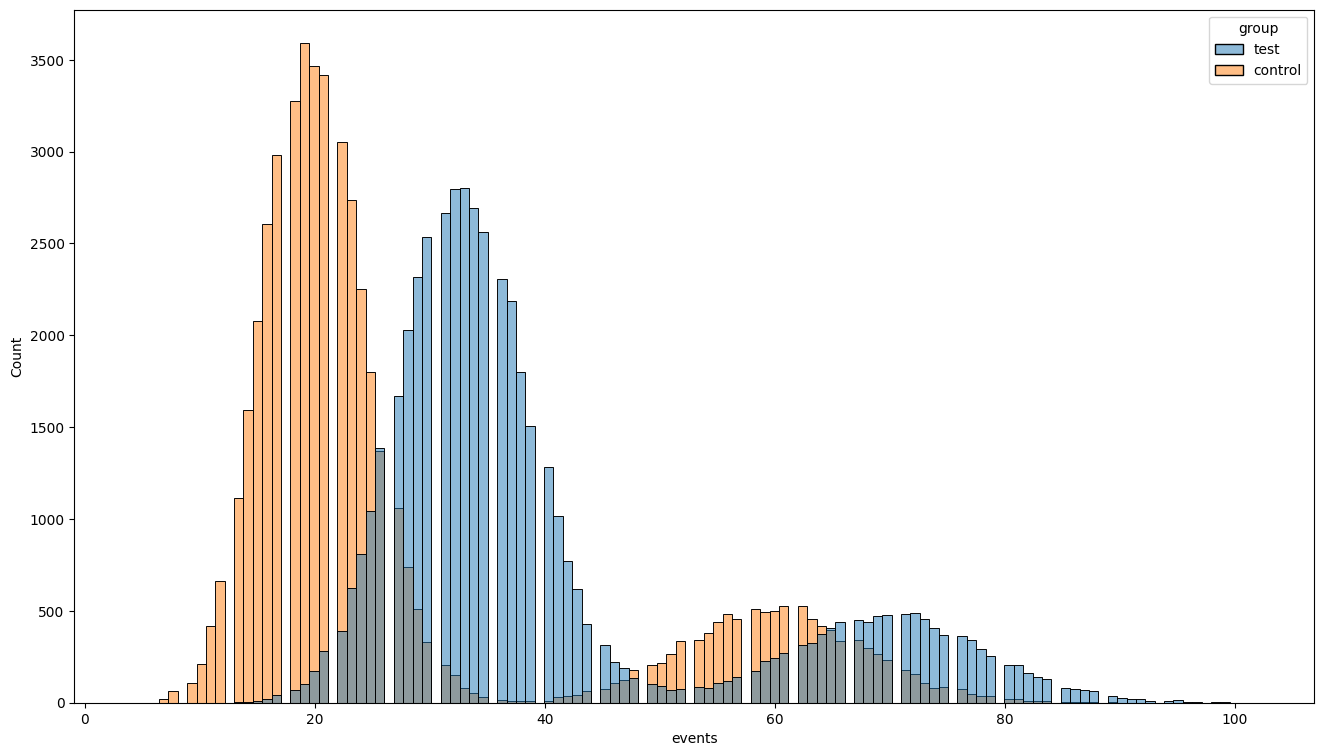

In [47]:
plt.figure(figsize=(16,9))
sns.histplot(data = button_df,x = 'events',hue= 'group')


In [48]:
button_df

,id,group,segment,events
0,83440,test,high,78.0
1,96723,test,high,71.0
2,68719,test,high,80.0
3,50399,test,high,80.0
4,95613,test,high,78.0
...,...,...,...,...
99995,60695,control,low,15.0
99996,5934,control,low,16.0
99997,30046,control,low,22.0
99998,26474,control,low,21.0


In [51]:
button_df.groupby(['group','segment'],as_index=False).agg( mean = ('events','mean'), median = ('events','median'),std = ('events','std'))

,group,segment,mean,median,std
0,control,high,59.970800,60.0,7.805347
1,control,low,20.031575,20.0,4.473576
2,test,high,69.938500,70.0,8.403974
3,test,low,33.025925,33.0,5.720845


### Шаг 9: Описательные статистики по группам и сегментам

Рассчитал ключевые метрики для оценки эффекта новой кнопки:

| Группа  | Сегмент | Среднее | Медиана | Стандартное отклонение |
|---------|---------|---------|---------|------------------------|
| control | high    | 59.97   | 60.0    | 7.81                   |
| control | low     | 20.03   | 20.0    | 4.47                   |
| test    | high    | 69.94   | 70.0    | 8.40                   |
| test    | low     | 33.03   | 33.0    | 5.72                   |

**Наблюдения:**
- Новая кнопка увеличила среднее количество заказов в обоих сегментах
- Эффект сильнее выражен в low-сегменте (+65% vs +17% в high)
- Распределения симметричны (среднее ≈ медиана)
- Разброс данных увеличился в test-группе

### Шаг 10: Двухфакторный дисперсионный анализ

In [52]:
formula = 'events ~ group + segment + group:segment'
model = smf.ols(data = button_df, formula=formula).fit()
anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
group,1.0,3.837195e+06,3.837195e+06,112031.864119,0.000000e+00
segment,1.0,2.362480e+07,2.362480e+07,689756.377485,0.000000e+00
group:segment,1.0,3.664244e+04,3.664244e+04,1069.823273,2.060261e-233
Residual,99996.0,3.424956e+06,3.425093e+01,NaN,NaN


**Результаты ANOVA:**

| Фактор         | F-статистика | p-value   | Значимость |
|----------------|--------------|-----------|------------|
| group          | 112,032      | 0.0       | ✅ **Да**   |
| segment        | 689,756      | 0.0       | ✅ **Да**   |
| group:segment  | 1,070        | 2.06e-233 | ✅ **Да**   |

**Выводы:**
- **Тип кнопки** значимо влияет на количество заказов
- **Сегмент пользователя** сильно влияет на результат  
- **Взаимодействие факторов** статистически значимо - эффект новой кнопки различается для high/low сегментов

Все эффекты статистически значимы, что подтверждает комплексное влияние изменений.

### Шаг 11: Post-hoc анализ с поправкой Тьюки

In [55]:
button_df['group/test'] = button_df.group + '/' + button_df.segment
button_df

,id,group,segment,events,group/test
0,83440,test,high,78.0,test/high
1,96723,test,high,71.0,test/high
2,68719,test,high,80.0,test/high
3,50399,test,high,80.0,test/high
4,95613,test,high,78.0,test/high
...,...,...,...,...,...
99995,60695,control,low,15.0,control/low
99996,5934,control,low,16.0,control/low
99997,30046,control,low,22.0,control/low
99998,26474,control,low,21.0,control/low


In [56]:
pg.pairwise_tukey(data = button_df, dv = 'events', between = 'group/test')

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,control/high,control/low,59.970800,20.031575,39.939225,0.065432,610.391461,0.0,7.521612
1,control/high,test/high,59.970800,69.938500,-9.967700,0.082766,-120.432523,0.0,-1.228989
2,control/high,test/low,59.970800,33.025925,26.944875,0.065432,411.798717,0.0,4.350026
3,control/low,test/high,20.031575,69.938500,-49.906925,0.065432,-762.727892,0.0,-9.091140
4,control/low,test/low,20.031575,33.025925,-12.994350,0.041383,-314.002699,0.0,-2.530414
5,test/high,test/low,69.938500,33.025925,36.912575,0.065432,564.135148,0.0,5.814008


**Ключевые результаты попарных сравнений:**

| Сравнение | Разница | p-value | Эффект (Hedges) |
|-----------|---------|---------|-----------------|
| control/low vs test/low | +12.99 | 0.0 | -2.53 |
| control/high vs test/high | +9.97 | 0.0 | -1.23 |

**Основные выводы:**
- Новая кнопка **значимо увеличила** количество заказов в обоих сегментах
- **Low-сегмент**: прирост +13 заказов (+65%)
- **High-сегмент**: прирост +10 заказов (+17%)
- **Наибольший эффект** в low-сегменте (Hedges = -2.53)


### Шаг 12: Визуализация результатов и итоговые выводы

<Axes: xlabel='segment', ylabel='events'>

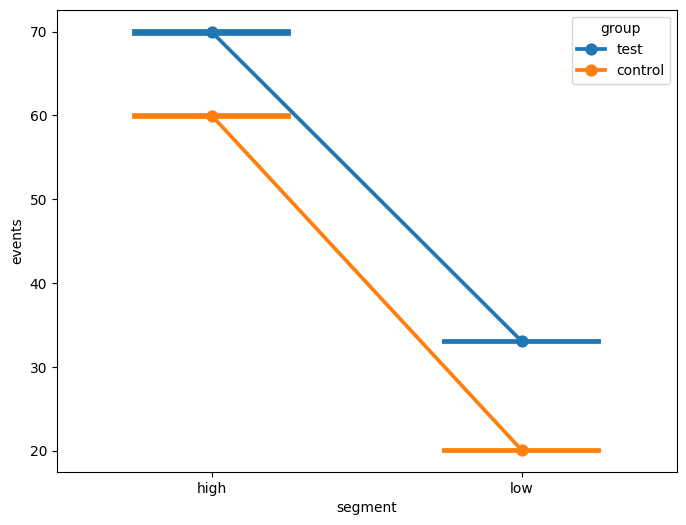

In [74]:
plt.figure(figsize=(8,6))
sns.pointplot(data = button_df , x = 'segment' , y = 'events' , hue = 'group', capsize = 0.5)

**Анализ графика:**
Для обоих сегментов среднее значение events **УВЕЛИЧИЛОСЬ** после внедрения новой кнопки, причем:
- Low-сегмент показал более выраженный рост
- High-сегмент также демонстрирует значимое улучшение

**Бизнес-решение:**
**ВЫКАТЫВАЕМ НОВУЮ ВЕРСИЮ** кнопки на всех пользователей

**Обоснование:**
Новый дизайн кнопки статистически значимо увеличивает количество заказов в обоих пользовательских сегментах, что подтверждается комплексным статистическим анализом.